In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.models
from torch import nn

import numpy as np
from matplotlib import pyplot as plt
import math
import pickle
import gzip
from pathlib import Path
import requests
from tqdm import tqdm
import pandas as pd
import os.path
from PIL import Image
from torchvision import transforms
from torchvision.transforms import _functional_tensor as F_t
import random

In [3]:
df = pd.read_csv('../../data/mpii/mpii_dataset.csv')
df

,Unnamed: 0,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,0,015601864.jpg,620,394,616,269,573,185,647,188,...,167,692,185,693,240,688,313,3.021046,curling,sports
1,0,015599452.jpg,-1,-1,-1,-1,806,543,720,593,...,281,719,299,711,516,545,466,5.641276,curling,sports
2,0,005808361.jpg,804,711,816,510,908,438,1040,454,...,253,1067,253,1167,353,1142,478,4.718488,curling,sports
3,0,086617615.jpg,301,461,305,375,201,340,294,342,...,261,314,264,327,320,362,346,2.681349,curling,sports
4,0,060111501.jpg,980,322,896,318,865,248,943,226,...,147,923,123,995,163,961,223,3.806403,curling,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17367,0,033474347.jpg,876,461,815,380,779,296,742,303,...,214,663,223,674,286,631,260,2.003677,pushing car,transportation
17368,0,082650067.jpg,1038,656,950,504,903,328,831,337,...,204,729,220,704,332,675,269,3.235820,pushing car,transportation
17369,0,072772110.jpg,562,617,558,539,553,452,511,458,...,377,490,378,470,411,461,414,1.494952,pushing car,transportation
17370,0,039361034.jpg,496,377,466,322,510,278,540,280,...,253,466,251,436,293,410,325,1.459468,pushing car,transportation


In [4]:
df.columns

Index(['Unnamed: 0', 'NAME', 'r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y',
       'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y', 'l knee_X', 'l knee_Y',
       'l ankle_X', 'l ankle_Y', 'pelvis_X', 'pelvis_Y', 'thorax_X',
       'thorax_Y', 'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y',
       'r wrist_X', 'r wrist_Y', 'r elbow_X', 'r elbow_Y', 'r shoulder_X',
       'r shoulder_Y', 'l shoulder_X', 'l shoulder_Y', 'l elbow_X',
       'l elbow_Y', 'l wrist_X', 'l wrist_Y', 'Scale', 'Activity', 'Category'],
      dtype='object')

In [5]:
df=df.rename(columns={'NAME':'filename'})
df['head_x'] = (df['head top_X']+df['upper neck_X']) / 2
df['head_y'] = (df['head top_Y']+df['upper neck_Y']) / 2
df = df[['filename', 'head_x', 'head_y']]
df = df.sample(frac=1)
df

,filename,head_x,head_y
2657,061279584.jpg,803.5,120.5
669,007513778.jpg,669.0,234.5
7052,015962993.jpg,818.5,211.5
10090,078562680.jpg,536.0,201.0
1934,058162229.jpg,127.0,144.5
...,...,...,...
6382,069548846.jpg,506.5,76.0
10592,034886210.jpg,141.0,212.5
637,013688563.jpg,767.0,149.0
2729,013545954.jpg,257.0,38.0


In [12]:
class HeadDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img_path = os.path.join(self.image_dir, row['filename'])
        head = torch.tensor([row['head_x'],row['head_y']], dtype=torch.float)
        
        img = Image.open(img_path)
        tfms = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                        std=(0.229, 0.224, 0.225))
             ])
        
        timg = tfms(img)

        # Resize to 224
        new_size = 224
        # Resize the target
        _, height, width = timg.shape
        if height > width:
            scale_factor = new_size / width 
        else:
            scale_factor = new_size / height
        head *= scale_factor
        # Resize the img
        timg = torchvision.transforms.Resize(new_size)(timg)
        
        new_size = 224
        _, height, width = timg.shape
        crop_height, crop_width = (new_size, new_size)
        if crop_width > width or crop_height > height:
            padding_ltrb = [
                (crop_width - width) // 2 if crop_width > image_width else 0,
                (crop_height - height) // 2 if crop_height > image_height else 0,
                (crop_width - width + 1) // 2 if crop_width > image_width else 0,
                (crop_height - height + 1) // 2 if crop_height > image_height else 0,
            ]
            head[0] += padding_ltrb[0]
            head[1] += padding_ltrb[1]
            timg = pad(timg, padding_ltrb, fill=0)  # PIL uses fill value 0
            _, height, width = timg.shape
            if crop_width == image_width and crop_height == image_height:
                return timg, head

        
        crop_top = int(round(max(0, head[1].item() - crop_height *random.uniform(0.2, 0.8))))
        crop_left = int(round(max(0, head[0].item() - crop_width *random.uniform(0.2, 0.8))))
        head[1] -= crop_top
        head[0] -= crop_left
        timg = F_t.crop(timg, crop_top, crop_left, crop_height, crop_width)
        return timg, head


dataset = HeadDataset(df, '../../data/mpii/images/')
x,y = dataset[0]
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([3, 224, 224]), torch.Size([2]), torch.float32, torch.float32)

In [13]:
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
len(train_dataset), len(valid_dataset)

(13898, 3474)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0000001].


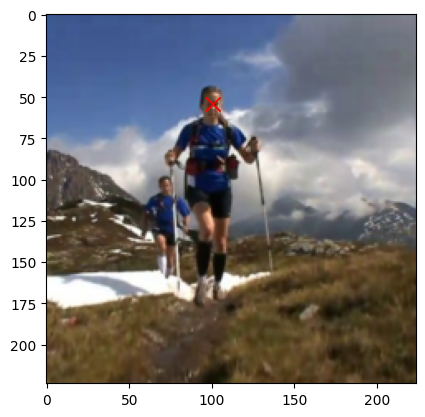

In [15]:
def show_sample(p, show_head=True):
    x,y = p
    invTrans = transforms.Compose([ transforms.Normalize(mean = (0., 0., 0. ),         std = (1/0.229, 1/0.224, 1/0.225)),
                                    transforms.Normalize(mean = (-0.485, -0.456, -0.406), std = (1., 1., 1. )) 
                                  ])
    x=invTrans(x)
    plt.imshow(  x.permute(1, 2, 0)  )
    if show_head:    
        plt.plot(y[0], y[1], "xr", markersize=10)

x,y=train_dataset[0]
show_sample((x,y))

In [8]:
resnet_model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)

In [9]:
resnet_model.fc = nn.Linear(in_features=512, out_features=2, bias=True)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [11]:
x,y=next(iter(train_dataloader))
x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 2]))

In [12]:
with torch.no_grad():
    z=resnet_model(x)
z.shape

torch.Size([32, 2])

In [13]:
def postprocessing(z):
    margin=224/100*5
    p=torch.nn.Sigmoid()(z)*(224+2*margin) - margin
    return p
postprocessing(z).shape

torch.Size([32, 2])

In [14]:
loss_fn = nn.MSELoss()

In [15]:
5/100*224

11.200000000000001

In [16]:
opt = torch.optim.Adam(resnet_model.parameters(), lr=0.001)

In [17]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
resnet_model = resnet_model.to(mps_device)

In [18]:
n_epochs = 7

for idx_epoch in range(n_epochs):
    # Loop de entrenamiento
    loss_train_sum = 0
    n_batches_train = 0
    resnet_model.train()
    for x_train_batch, y_train_batch in tqdm(train_dataloader):
        x_train_batch = x_train_batch.to(mps_device)
        y_train_batch = y_train_batch.to(mps_device)
        z = resnet_model(x_train_batch)
        predictions = postprocessing(z)
        loss = loss_fn(predictions, y_train_batch)
        loss_train_sum += loss.item()
        n_batches_train += 1
        opt.zero_grad()
        loss.backward()
        opt.step()

    # Evaluamos los datos en validación
    loss_validation_sum = 0
    n_batches_valid = 0
    resnet_model.eval()
    for x_valid_batch, y_valid_batch in tqdm(valid_dataloader):
        x_valid_batch = x_valid_batch.to(mps_device)
        y_valid_batch = y_valid_batch.to(mps_device)
        z = resnet_model(x_valid_batch)
        predictions = postprocessing(z)
        loss = loss_fn(predictions, y_valid_batch)
        loss_validation_sum += loss.item()
        n_batches_valid += 1
    
    # Imprimimos el loss en train y validación y la métrica (siempre en validación)
    loss_validation = loss_validation_sum / n_batches_valid
    train_validation = loss_train_sum / n_batches_train
    print(f'epoch {idx_epoch} | train loss {loss_validation} | validation loss {train_validation}')

100%|██████████████████████████| 109/109 [01:10<00:00,  1.54it/s]


epoch 0 | train loss 369.7077609420916 | validation loss 554.7816154216898


100%|██████████████████████████| 109/109 [01:10<00:00,  1.55it/s]


epoch 1 | train loss 463.2196221307877 | validation loss 335.0680457454988


100%|██████████████████████████| 109/109 [01:12<00:00,  1.51it/s]


epoch 2 | train loss 283.09519496532755 | validation loss 301.66907903737035


100%|██████████████████████████| 109/109 [40:08<00:00, 22.10s/it]


epoch 3 | train loss 291.91312919406715 | validation loss 289.84941999062727


100%|██████████████████████████| 109/109 [10:36<00:00,  5.84s/it]


epoch 4 | train loss 309.9573236867922 | validation loss 284.86862203663793


100%|███████████████████████| 109/109 [3:30:14<00:00, 115.73s/it]


epoch 5 | train loss 261.33240015572363 | validation loss 253.30417029720613


100%|██████████████████████████| 109/109 [21:28<00:00, 11.82s/it]

epoch 6 | train loss 293.6395157280318 | validation loss 240.32849049184514


In [19]:
import math
math.sqrt(140)

11.832159566199232

In [20]:
x,y=dataset[2]
x.shape, y.shape

(torch.Size([3, 224, 224]), torch.Size([2]))

In [21]:
def predict_head(x):
    resnet_model.eval()
    with torch.no_grad():
        xb=x.unsqueeze(0)
        z = resnet_model(xb.to(mps_device))
        predicted_head = postprocessing(z).to('cpu')
    return predicted_head[0,:]

predicted_head = predict_head(x)
predicted_head.shape

torch.Size([2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0003656149..1.0000001].


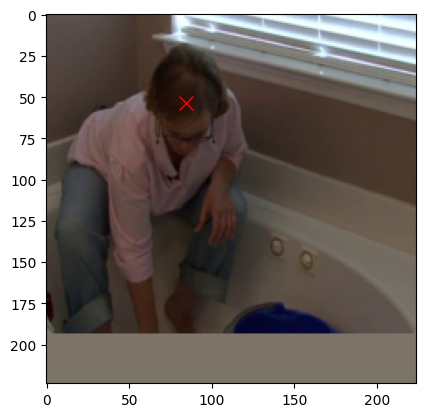

In [22]:
show_sample((x,y))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0003656149..1.0000001].


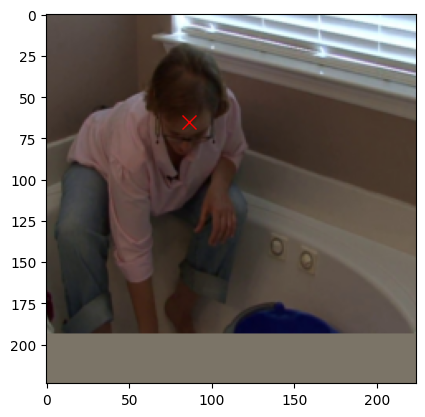

In [23]:
show_sample((x,predicted_head))

In [39]:
invTrans = transforms.Compose([ transforms.Normalize(mean = (0., 0., 0. ),         std = (1/0.229, 1/0.224, 1/0.225)),
                                    transforms.Normalize(mean = (-0.485, -0.456, -0.406), std = (1., 1., 1. )) 
                                  ])
x=invTrans(x)


torch.Size([3, 224, 224])

In [49]:
a=x
a[0,:,100]=1
a.shape

torch.Size([3, 224, 224])

In [44]:
p=transforms.ToPILImage()(x)
p.save('a.bmp')

In [ ]:
x[101.8, 122.1)

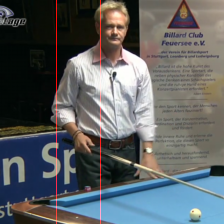

In [50]:
transforms.ToPILImage()(x)

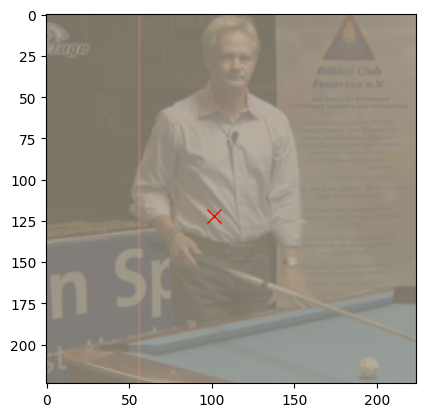

In [48]:
show_sample((x,(101, 122)))

In [47]:
y

tensor([111.8445,  24.8889])